In [2]:
import os
import tensorflow.keras.backend as K
import tensorflow as tf

In [3]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

In [4]:
# Dataset link:
# https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small?resource=download

In [5]:
img_height = 64 
img_width = 64
channels = 3 
batch_size = 50 

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   validation_split=0.2,                            
                                   rotation_range=180,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,)

training_set = train_datagen.flow_from_directory(
    './kaggle_fashion_dataset',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

validation_set = train_datagen.flow_from_directory(
    './kaggle_fashion_dataset',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'validation',
     shuffle=False)

Found 71106 images belonging to 2 classes.
Found 17776 images belonging to 2 classes.


In [6]:
def get_processed_img(img_path, size=(64, 64)):
    img = load_img(img_path, target_size = size)
    img = img_to_array(img) / 255.0 
    img = np.expand_dims(img, axis=0)
    return img

In [8]:
dir_It = training_set

(50, 64, 64, 3)


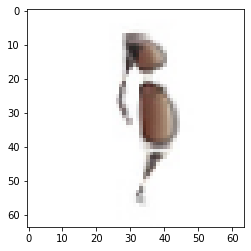

(50, 64, 64, 3)


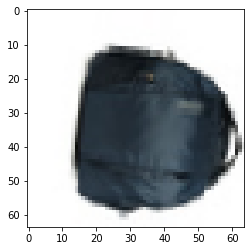

(50, 64, 64, 3)


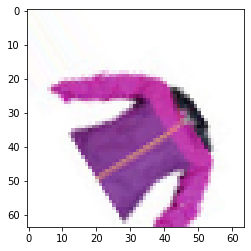

(50, 64, 64, 3)


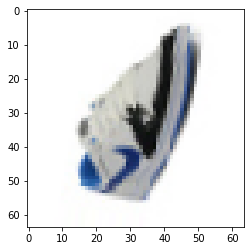

(50, 64, 64, 3)


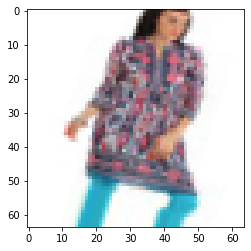

(50, 64, 64, 3)


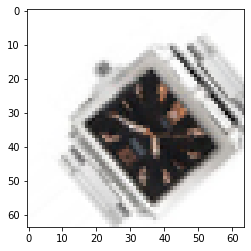

(50, 64, 64, 3)


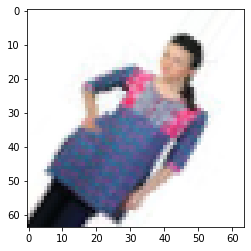

(50, 64, 64, 3)


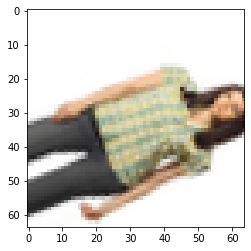

(50, 64, 64, 3)


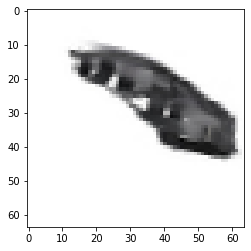

(50, 64, 64, 3)


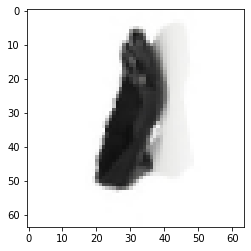

(50, 64, 64, 3)


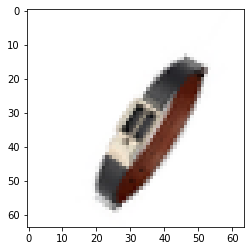

In [9]:
for _ in range(11): 
    img, label = dir_It.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

In [10]:
print(training_set)

In [12]:
input_model = Input(shape=(img_height, img_width, channels))

encoder = Conv2D(32, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder_dim = K.int_shape(encoder)  
encoder = Flatten()(encoder)   

latent_space = Dense(64, name='latent_space')(encoder)

decoder = Dense(np.prod(encoder_dim[1:]))(latent_space)
decoder = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(3, (3, 3), padding="same")(decoder)
output = Activation('sigmoid', name='decoder')(decoder)  


autoencoder = Model(input_model, output, name='autoencoder')


autoencoder.compile(loss="mse", optimizer= tf.keras.optimizers.Adam(lr=0.003))  

history = autoencoder.fit(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=15,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [ModelCheckpoint('models/image_autoencoder_test.h5', 
                                       monitor='val_loss', 
                                       verbose=0, 
                                       save_best_only=True,   
                                       save_weights_only=False)]) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
1423/1423 [==============================] - 474s 333ms/step - loss: 0.0170 - val_loss: 0.0115
Epoch 2/15
1423/1423 [==============================] - 401s 282ms/step - loss: 0.0087 - val_loss: 0.0161
Epoch 3/15
1423/1423 [==============================] - 414s 291ms/step - loss: 0.0076 - val_loss: 0.0084
Epoch 4/15
1423/1423 [==============================] - 405s 285ms/step - loss: 0.0069 - val_loss: 0.0091
Epoch 5/15
1423/1423 [==============================] - 367s 258ms/step - loss: 0.0066 - val_loss: 0.0076
Epoch 6/15
1423/1423 [==============================] - 285s 200ms/step - loss: 0.0063 - val_loss: 0.0076
Epoch 7/15
1423/1423 [==============================] - 207s 146ms/step - loss: 0.0061 - val_loss: 0.0070
Epoch 8/15
1423/1423 [==============================] - 179s 125ms/step - loss: 0.0060 - v

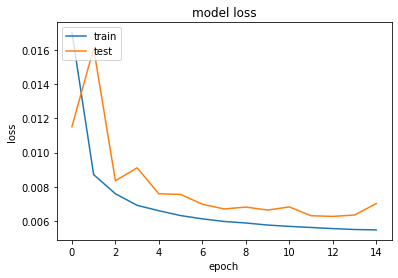

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
print(type(encoder))  
print(type(decoder))

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


In [15]:
autoencoder.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 64, 64, 64)        256       
__________

In [16]:
latent_space_model = Model(autoencoder.input, autoencoder.get_layer('latent_space').output) 

In [17]:
decoder_layer = Model(autoencoder.input, autoencoder.get_layer('decoder').output) 

In [7]:
def get_embeddings_for_folder(folder):
    images_loaded = []
    X = []
    indices = []

    for i in tqdm(range(len(os.listdir(folder)))):
        try:
            img_name = os.listdir(folder)[i]
            img = get_proccessed_img(img_name)
            images_loaded.append(img)
            pred = latent_space_model.predict(img)  
            pred = np.resize(pred, (16))
            X.append(pred)
            indices.append(img_name)
        except Exception as e:
            print(img_name)
            print(e)
    return X, indices, images_loaded

In [8]:
def get_embeddings_for_all_inner_folders(folder):
    X = []
    indices = []
    images_loaded = []
    for filename in os.listdir(folder):
        inner_dir_path = os.path.join(folder, filename)
        isDirectory = os.path.isdir(inner_dir_path)
        current_files = []
        if isDirectory:
            for inner_file in os.listdir(inner_dir_path):
                img_path = os.path.join(inner_dir_path, inner_file)
                current_files.append(img_path)
        else:
            current_files.append(inner_dir_path)
        for f in current_files:
            try:
                img = get_processed_img(f)
                images_loaded.append(img)
                pred = latent_space_model.predict(img)
                pred = np.resize(pred, (16))
                X.append(pred)
                indices.append(f)
            except Exception as e:
                print(f, e)
    return X, indices, images_loaded

In [9]:
def show_image(img):
    img_pred = decoder_layer.predict(img)

    plt.imshow(np.squeeze(img))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(np.squeeze(img))

    plt.subplot(1,2,2)
    plt.title("Code")
    plt.imshow(np.squeeze(img_pred))
    plt.show()


In [21]:
X_jackets, indices_jackets, images_loaded_jackets = get_embeddings_for_all_inner_folders('./dataset/man/jackets')

./dataset/man/jackets/.DS_Store cannot identify image file './dataset/man/jackets/.DS_Store'


In [22]:
X_shoes, indices_shoes, images_loaded_shoes = get_embeddings_for_all_inner_folders('./dataset/man/shoes')

./dataset/man/shoes/.DS_Store cannot identify image file './dataset/man/shoes/.DS_Store'


In [23]:
X_suits, indices_suits, images_loaded_suits = get_embeddings_for_all_inner_folders('./dataset/man/suits')

./dataset/man/suits/.DS_Store cannot identify image file './dataset/man/suits/.DS_Store'


In [24]:
X_dresses, indices_dresses, images_loaded_dresses = get_embeddings_for_all_inner_folders('./dataset/women/dresses')

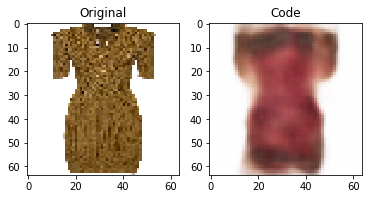

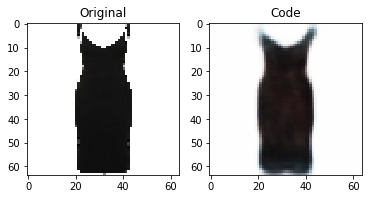

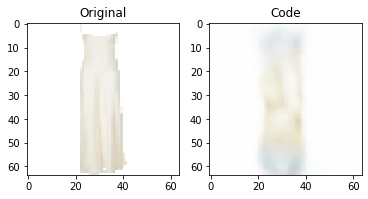

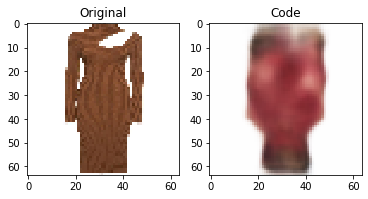

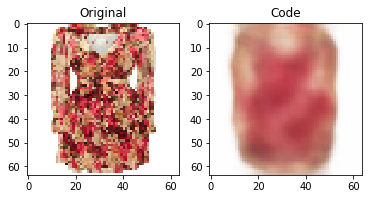

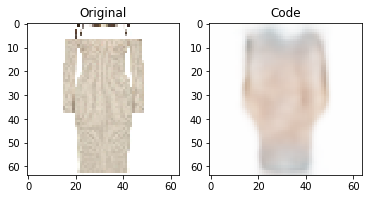

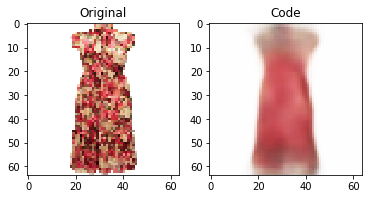

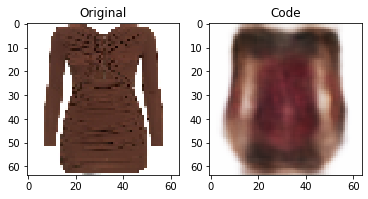

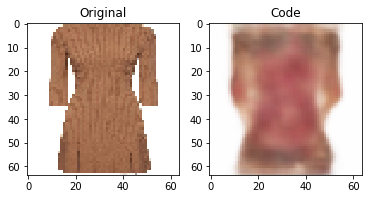

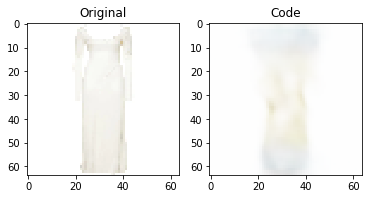

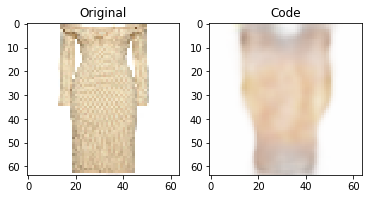

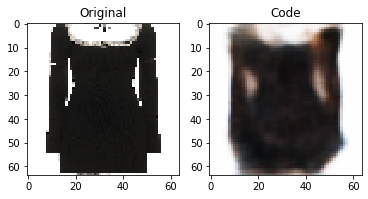

In [26]:
for s in images_loaded_dresses:
    show_image(s)

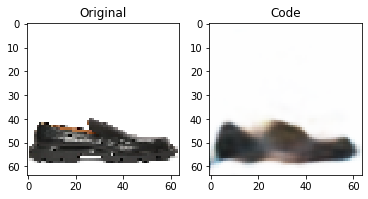

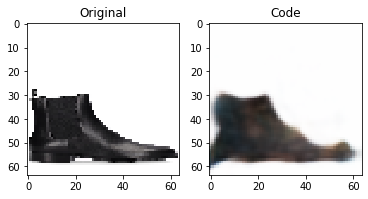

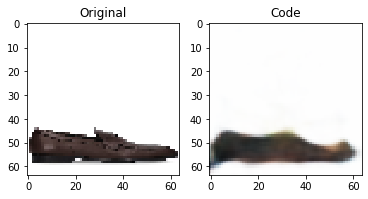

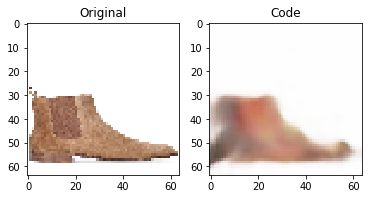

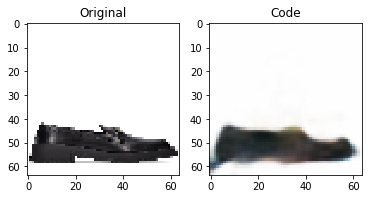

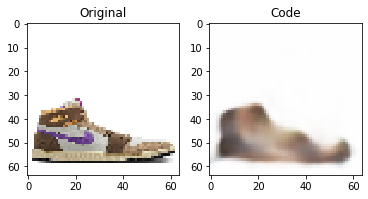

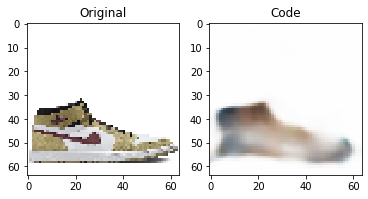

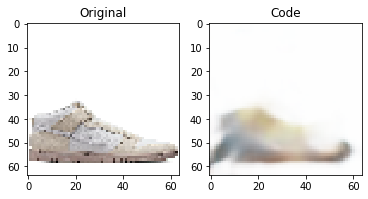

In [27]:
for s in images_loaded_shoes:
    show_image(s)

In [28]:
X_jeans, indices_jeans, images_loaded_jeans = get_embeddings_for_all_inner_folders('./dataset/man/jeans')

./dataset/man/jeans/.DS_Store cannot identify image file './dataset/man/jeans/.DS_Store'


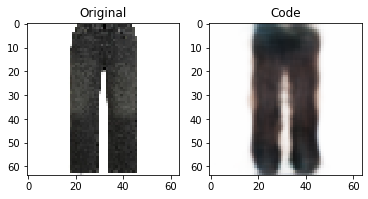

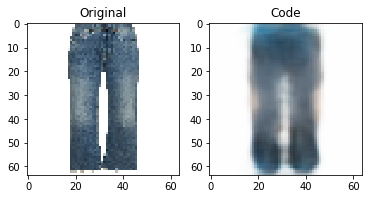

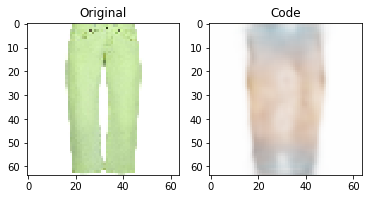

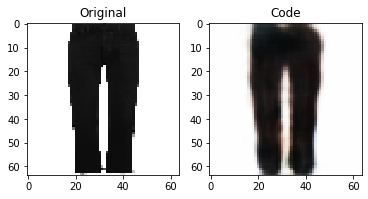

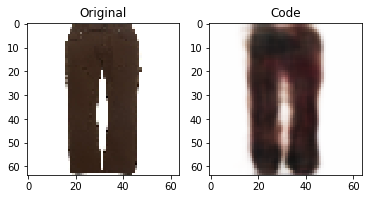

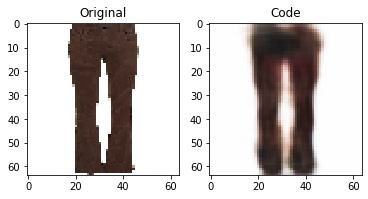

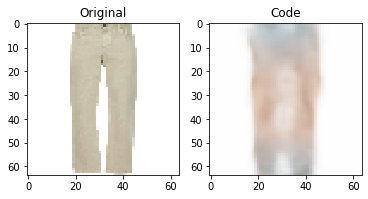

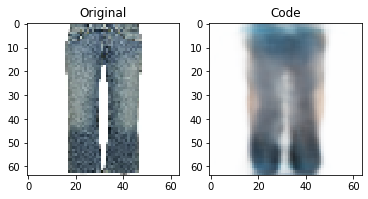

In [29]:
for s in images_loaded_jeans:
    show_image(s)

In [30]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

In [32]:
def get_index_of_file_name(indeces, file_name):
    for i in range(0, len(indeces)):
        just_file = indeces[i].split('/')[4]
        if just_file == file_name:
            return i
    return None

### NearestNeighbors

In [13]:
model_path = r'./models/autoencoder_fashion_dataset.h5'
model = tf.keras.models.load_model(model_path)
latent_space_model = tf.keras.models.Model(model.input, model.get_layer('latent_space').output)

Metal device set to: Apple M1


In [15]:
X_all, indices_all, images_loaded_all = get_embeddings_for_all_inner_folders(r'/Users/yasminabocereg/Desktop/LAST DATASET')

/Users/yasminabocereg/Desktop/LAST DATASET/.DS_Store cannot identify image file <_io.BytesIO object at 0x1215855e0>


2023-06-24 16:02:14.325261: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 11ms/step
/Users/yasminabocereg/Desktop/LAST DATASET/m/.DS_Store cannot identify image file <_io.BytesIO object at 0x125cf0810>
1/1 [==============================] - 0s 10ms/step
/Users/yasminabocereg/Desktop/LAST DATASET/w/.DS_Store cannot identify image file <_io.BytesIO object at 0x12654b2c0>
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


In [16]:
knn = NearestNeighbors(n_neighbors=3, metric="cosine")
knn.fit(X_all)

NearestNeighbors(metric='cosine', n_neighbors=3)

In [17]:
for X in X_all[20:25]:
    dist, neighbors = knn.kneighbors([X])
    print(dist)
    print(neighbors)
    ind = 0
    for n_l in neighbors[0]:
        print(indices_all[n_l], dist[0][ind])
        ind += 1

[[0.         0.06117308 0.07261044]]
[[20 68 56]]
/Users/yasminabocereg/Desktop/LAST DATASET/m/015_e9618629-285b-435e-a6e0-6b55cea58b2c.png 0.0
/Users/yasminabocereg/Desktop/LAST DATASET/m/036_59cc5739-1829-46ba-a876-3e634d168063.png 0.06117308
/Users/yasminabocereg/Desktop/LAST DATASET/m/018_c35c5d85-b366-42d4-90f5-df17abbca54e.png 0.07261044
[[0.         0.03814626 0.06082463]]
[[ 21  42 115]]
/Users/yasminabocereg/Desktop/LAST DATASET/m/011_cfd104a4-1aeb-4aa0-b0d8-8b13f94b3c23.png 0.0
/Users/yasminabocereg/Desktop/LAST DATASET/m/082_db2c00aa-7e1b-417d-aa0f-895712181215.png 0.038146257
/Users/yasminabocereg/Desktop/LAST DATASET/w/073_7d37954a-0d0a-4868-8018-8cd2c9a0774d.png 0.060824633
[[5.9604645e-08 2.7849257e-02 3.5444558e-02]]
[[22 36 79]]
/Users/yasminabocereg/Desktop/LAST DATASET/m/074_1df33158-7052-4f43-933c-e2406b321843.png 5.9604645e-08
/Users/yasminabocereg/Desktop/LAST DATASET/m/109_738aa91c-8630-4843-bcf8-a3fa3c6e1e21.png 0.027849257
/Users/yasminabocereg/Desktop/LAST DAT

In [18]:
with open('./models/indices_file_test_nou_final.txt', 'w') as of:
    for i in indices_all:
        of.write(i + '\n')

In [19]:
import pickle

In [20]:

knnPickle = open('./models/knnpickle_file_test_nou_final.pickle', 'wb') 

In [21]:
pickle.dump(knn, knnPickle)  

In [22]:
knnPickle.close()